In [1]:
from IPython.display import clear_output as cls

In [2]:
# data no split
# https://drive.google.com/file/d/1ey1O_1cZEnqP8s4mHjCvT8vpfAOlvP9L/view?usp=sharing

# data with split - train val test
# https://drive.google.com/file/d/14Rjq65k_qzXDje0atzyDl9WziapGaifp/view?usp=sharing

# data with split and converted - train val test
# https://drive.google.com/file/d/10eYtkh6bTWNwH_--xZtU8IxB5cZPVc3O/view?usp=drive_link
    
# data with split and converted clean - train val test
# https://drive.google.com/file/d/184s1XY7oZ2ukeMUzhMjH-MEXROGuGCk3/view?usp=drive_link
!pip install gdown

!rm -r dataset
!gdown "https://drive.google.com/uc?id=184s1XY7oZ2ukeMUzhMjH-MEXROGuGCk3" -O dataset.zip
!unzip dataset.zip -d dataset

cls()

In [3]:
# common
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from tqdm import tqdm
from glob import glob
from datetime import datetime

# preprocessing
from tensorflow import image as tfi

# architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception, InceptionV3, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# output cell
from IPython.display import clear_output as cls

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
train_dir = '/kaggle/working/dataset/clean_data_splitted_convert/train/'
val_dir = '/kaggle/working/dataset/clean_data_splitted_convert/val/'
test_dir = '/kaggle/working/dataset/clean_data_splitted_convert/test/'

In [5]:
# Constants

IMAGE_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 50

# LEARNING_RATE = 2e-5
LEARNING_RATE = 1e-3


LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = ['accuracy']

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

## Data Loading

In [6]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Show
print(f"Total number of classes in train: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes in train: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


### Check Corrupt Data

In [7]:
def load_image(image_path: str) -> tf.Tensor:
    
    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some 
    preprocessing steps such as resizing and normalization.
    
    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.
        
    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''
    
    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'
    
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Load the image
    try:
        image = tfi.decode_jpeg(image, channels=3)
    except:
        image = tfi.decode_png(image, channels=3)
    
    # Change the image data type
    image = tfi.convert_image_dtype(image, tf.float32)
    
    # Resize the Image
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image

In [8]:
def load_dataset(root_path: str, class_names: list, batch_size: int = 32, buffer_size: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        batch_size (int): Batch size of the final dataset. Defaults to 32.
        buffer_size (int): Buffer size to use when shuffling the data. Defaults to 1000.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''

    # Collect total number of data samples
    n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    errors = []
    
    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        for file_path in glob(os.path.join(class_path, "*")):
            # Load the image
            try:
                image = load_image(file_path)
                
                # Assign label
                label = class_names.index(class_name)

                # Store the image and the respective label
                images[n_image] = image
                labels[n_image] = label

                # Increment the number of images processed
                n_image += 1
                
            except:
                errors.append(file_path)
            
    # Shuffle the data
    indices = np.random.permutation(n_samples)
    images = images[indices]
    labels = labels[indices]
    
    print('num of errors:', len(errors))

    return images, labels, errors

### to check corrupt data

In [9]:
# # Load the training dataset
# X_train, y_train, err_train = load_dataset(root_path = train_dir, class_names = class_names)

# # # Load the validation dataset
# X_valid, y_valid, err_val = load_dataset(root_path = val_dir, class_names = class_names)

# # Load the testing dataset
# X_test, y_test, err_test = load_dataset(root_path = test_dir, class_names = class_names)

In [10]:
# print('train err:', err_train)
# print('val err:', err_val)
# print('test err:', err_test)

In [11]:
# del X_train, y_train, X_valid, y_valid, X_test, y_test

### Drop corrupted data

In [12]:
corrupted = '/kaggle/working/dataset/clean_data_splitted_convert/train/ra/000021.jpg'
os.remove(corrupted)

### Augmentasi

In [13]:
pass

### Input Preprocessing Pipeline

- Rescaling
- Standardization

In [14]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
#     # Convert image data type to tf.float32
#     image = tf.cast(image, tf.float32)
    
    return image, label

### Load with Tensor Datasets

In [15]:
# del train_ds, val_ds, test_ds
# del train_ds_mapped, val_ds_mapped, test_ds_mapped

# Create a dataset from the data directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
#                                                                labels='inferred', 
#                                                                label_mode='int',
#                                                                image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size=BATCH_SIZE
                                                              )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
#                                                              labels='inferred', 
#                                                              label_mode='int',
#                                                              image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE
                                                              )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
#                                                               labels='inferred', 
#                                                               label_mode='int',
#                                                               image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size=BATCH_SIZE
                                                              )

Found 3404 files belonging to 20 classes.
Found 207 files belonging to 20 classes.
Found 202 files belonging to 20 classes.


### preprocessing

In [16]:
train_ds_mapped = train_ds.map(load_and_preprocess_image)
val_ds_mapped = val_ds.map(load_and_preprocess_image)
test_ds_mapped = test_ds.map(load_and_preprocess_image)

### Data Distribution

In [17]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(val_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(test_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

### Data Visualization

In [18]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 1.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (10, 10).
    """
    
    for images, labels in dataset.take(1):
#     images, labels = next(iter(dataset))
    
        # Create a figure to display the images
        fig = plt.figure(figsize=figsize)

        # Loop over the number of rows and columns
        for i in range(n_rows * n_cols):

            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis])

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, i+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Show the plot
    plt.show()

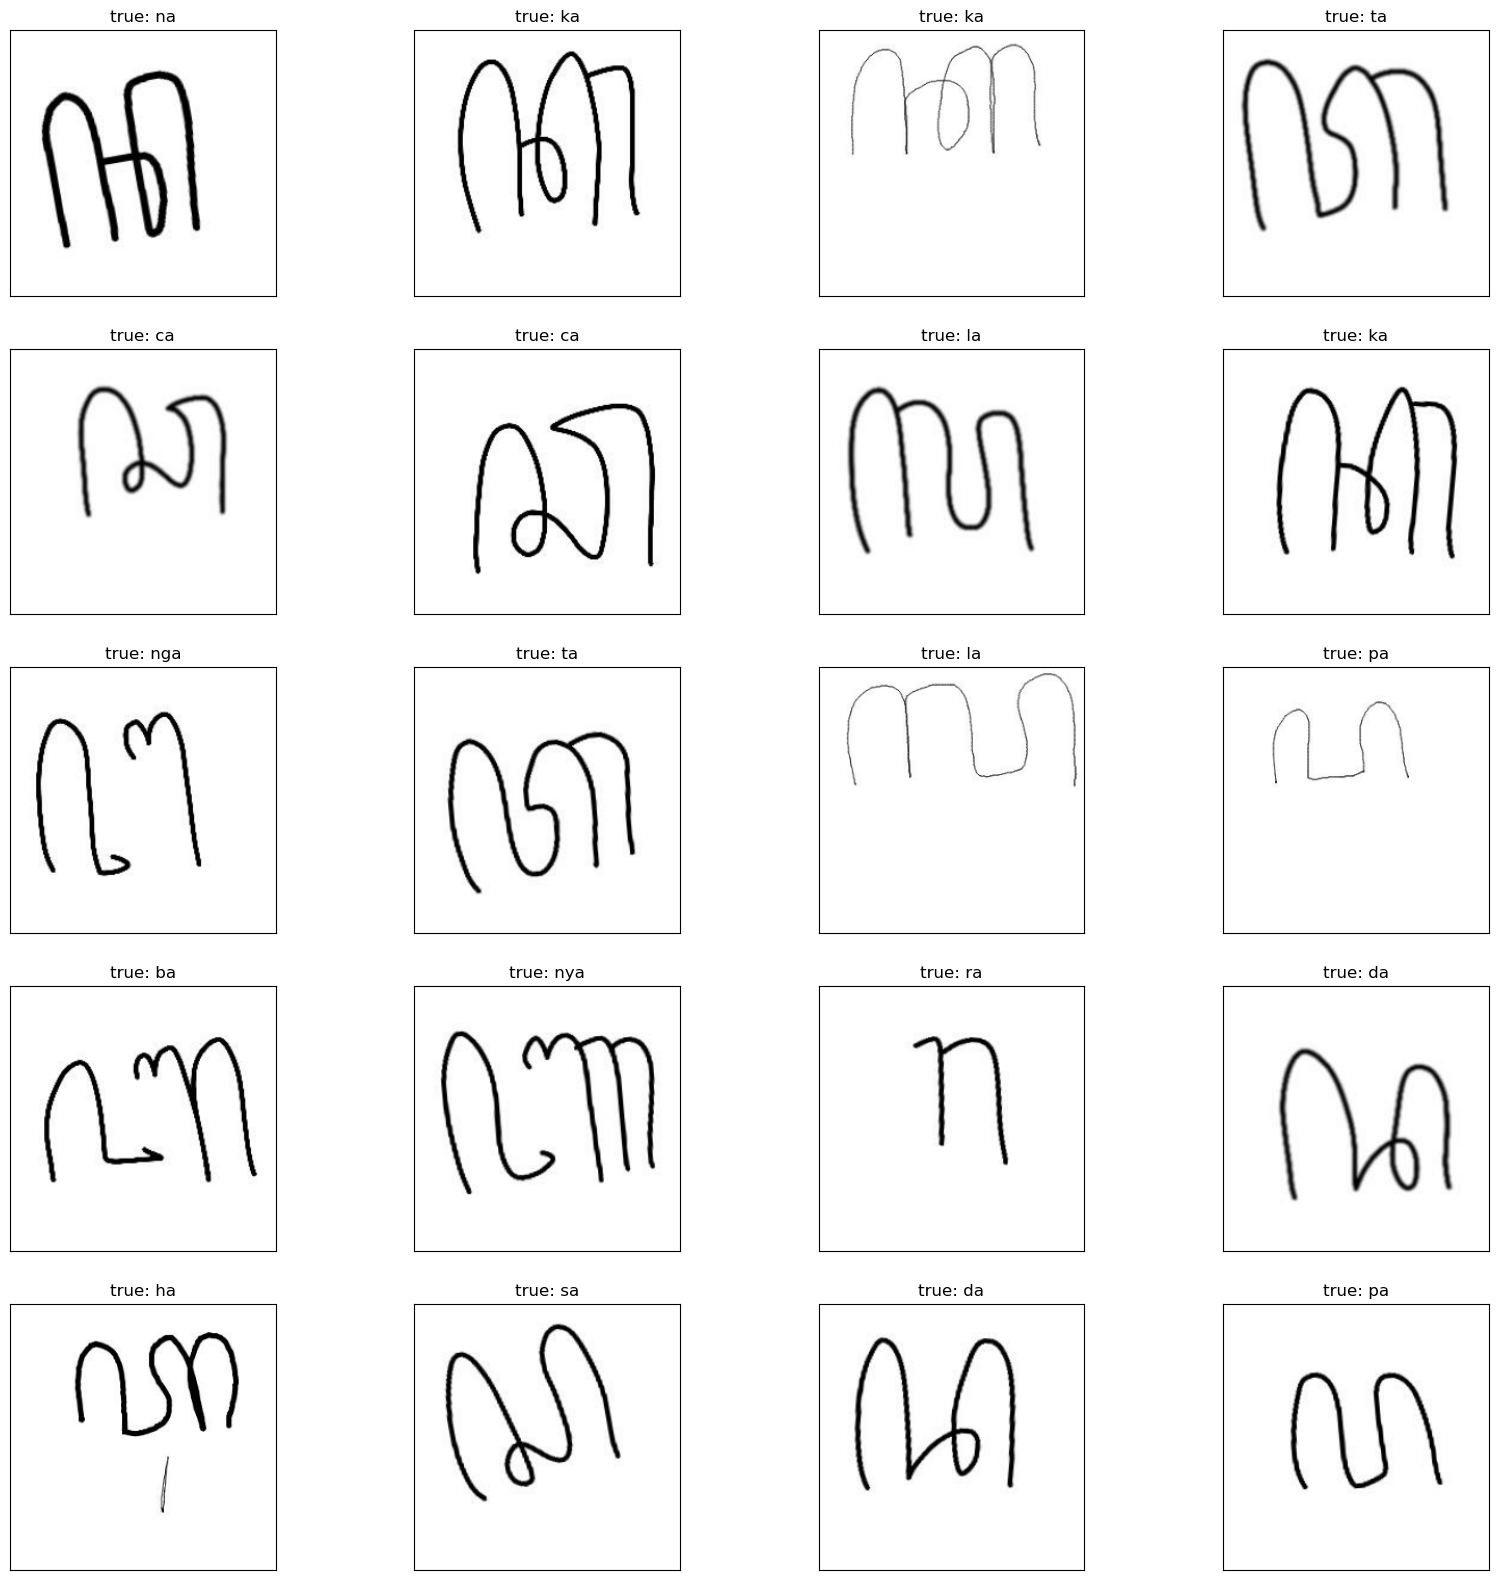

In [19]:
plot_images(train_ds)

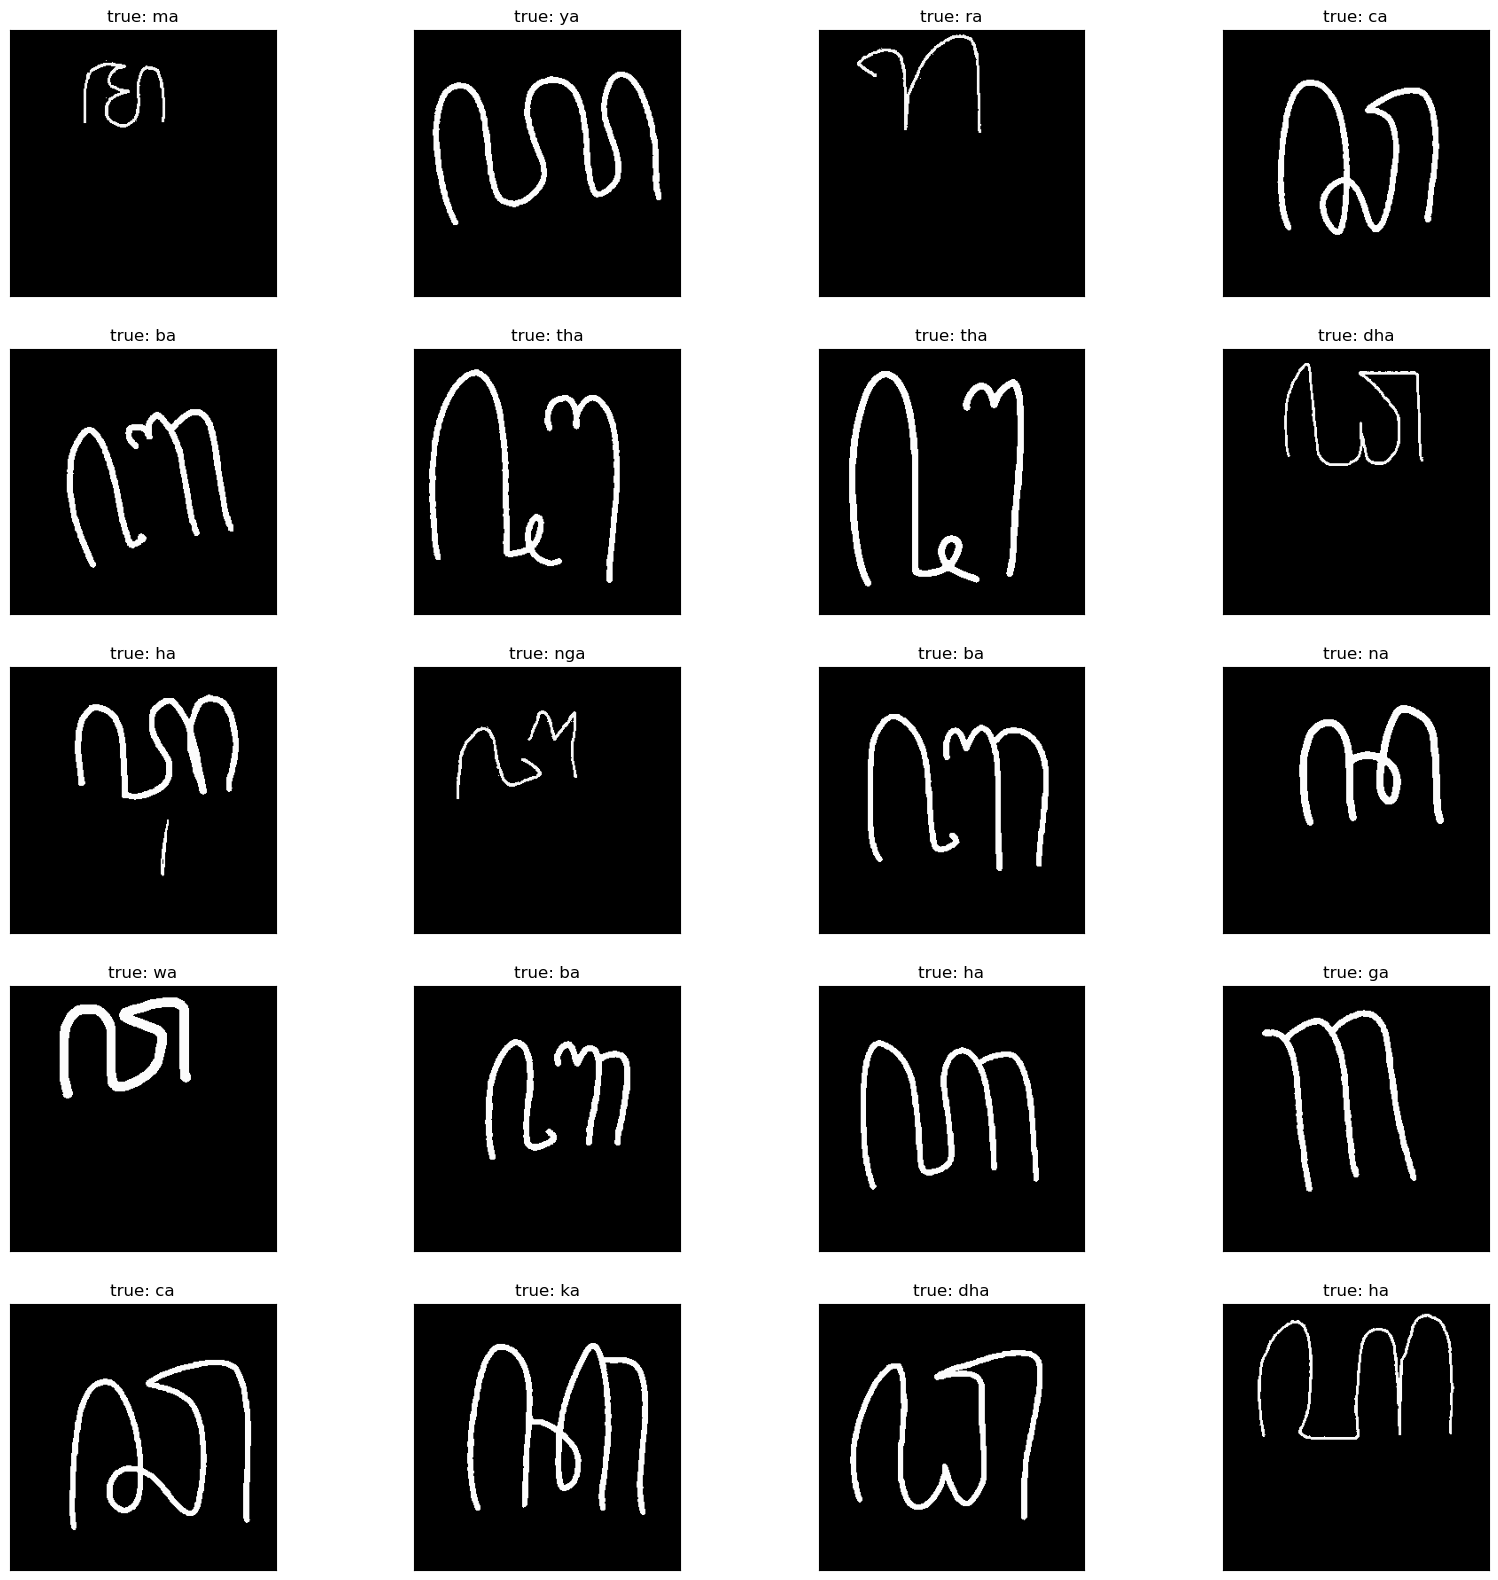

In [20]:
plot_images(train_ds_mapped)

## Train and Fine Tuning

In [21]:
def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    """
    Measures the time elapsed from a given start time.

    If no start time is provided, returns the current time. If a start time is provided, returns a formatted string
    representing the time elapsed from the start time to the current time.

    Args:
        start_time (datetime.datetime, optional): The start time to measure elapsed time from, or None to get the current time. Defaults to None.

    Returns:
        Union[datetime.datetime, str]: The current time if no start time is provided, or a formatted string representing the elapsed time.
    """
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [22]:
def plot_history(history):
    # Collect the history of the training run
    history_plot = pd.DataFrame(history.history)
    
    # Create a figure to display the model's performance
    plt.figure(figsize=(20, 5))

    # Plot the loss curve in the first subplot
    plt.subplot(1, 2, 1)
    plt.title("VGG16 - Loss Curve")
    plt.plot(history_plot['loss'], label="Training Loss")
    plt.plot(history_plot['val_loss'], label="Validation Loss")

    # Horizontal line to show the testing performance
    plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

    # Set the x- and y-labels, and the x- and y-limits
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    # plt.ylim([0, 0.4])

    # Show the legend and grid
    plt.legend()
    plt.grid()

    # Plot the accuracy curve in the second subplot
    plt.subplot(1, 2, 2)
    plt.title("VGG16 - Accuracy Curve")
    plt.plot(history_plot['accuracy'], label="Training Accuracy")
    plt.plot(history_plot['val_accuracy'], label="Validation Accuracy")

    # Horizontal line to show the testing performance
    plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

    # Set the x- and y-labels, and the x- and y-limits
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    # plt.ylim([0.85, 1])

    # Show the legend and grid
    plt.legend()
    plt.grid()

    # Display the plot
    plt.show()

### Full Freeze

In [23]:
# VGG16

vgg = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

vgg.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [24]:
name = 'aksara_jawa_vgg_full_freeze_v1'

vgg_transferred_full = Sequential([
    vgg,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
], name=name)

vgg_transferred_full.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

vgg_transferred_full.summary()

Model: "aksara_jawa_vgg_full_freeze_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 20)                10260     
                                                                 
Total params: 14,724,948
Trainable params: 10,260
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
# Print the trainable status of each layer
for layer in vgg_transferred_full.layers:
    print(f'{layer.name}: {layer.trainable}')

vgg16: False
global_average_pooling2d: True
dropout: True
dense: True


In [26]:
print(f"\nTraining {name} Model: ")

# steps_per_epoch = len(X_train)
# STEPS_PER_EPOCH = 50

time = timer(None)
history_full = vgg_transferred_full.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(f"checkpoint-{name}.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH
)
time_taken = timer(time)
print(time_taken)


Training aksara_jawa_vgg_full_freeze_v1 Model: 
Epoch 1/50
107/107 [==============================] - 31s 194ms/step - loss: 3.0832 - accuracy: 0.0661 - val_loss: 2.8499 - val_accuracy: 0.2657
Epoch 2/50
107/107 [==============================] - 15s 140ms/step - loss: 2.8646 - accuracy: 0.1293 - val_loss: 2.7154 - val_accuracy: 0.4251
Epoch 3/50
107/107 [==============================] - 16s 145ms/step - loss: 2.7176 - accuracy: 0.2030 - val_loss: 2.5948 - val_accuracy: 0.4976
Epoch 4/50
107/107 [==============================] - 15s 140ms/step - loss: 2.6086 - accuracy: 0.2609 - val_loss: 2.4831 - val_accuracy: 0.6232
Epoch 5/50
107/107 [==============================] - 16s 147ms/step - loss: 2.5134 - accuracy: 0.3070 - val_loss: 2.3846 - val_accuracy: 0.6232
Epoch 6/50
107/107 [==============================] - 15s 140ms/step - loss: 2.4143 - accuracy: 0.3678 - val_loss: 2.2972 - val_accuracy: 0.6329
Epoch 7/50
107/107 [==============================] - 16s 148ms/step - loss: 2.33

In [27]:
test_loss, test_acc = vgg_transferred_full.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

7/7 [==============================] - 2s 308ms/step - loss: 1.0650 - accuracy: 0.8564
Loss    : 1.065
Accuracy: 85.64%


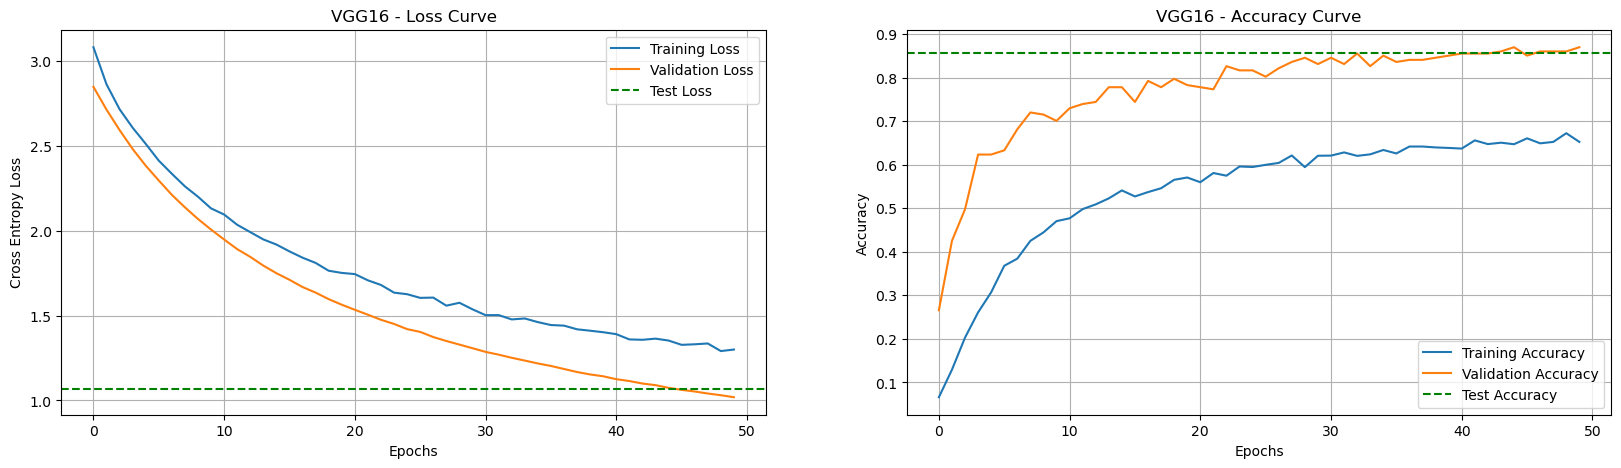

In [28]:
plot_history(history_full)

1/1 [==============================] - 0s 18ms/step


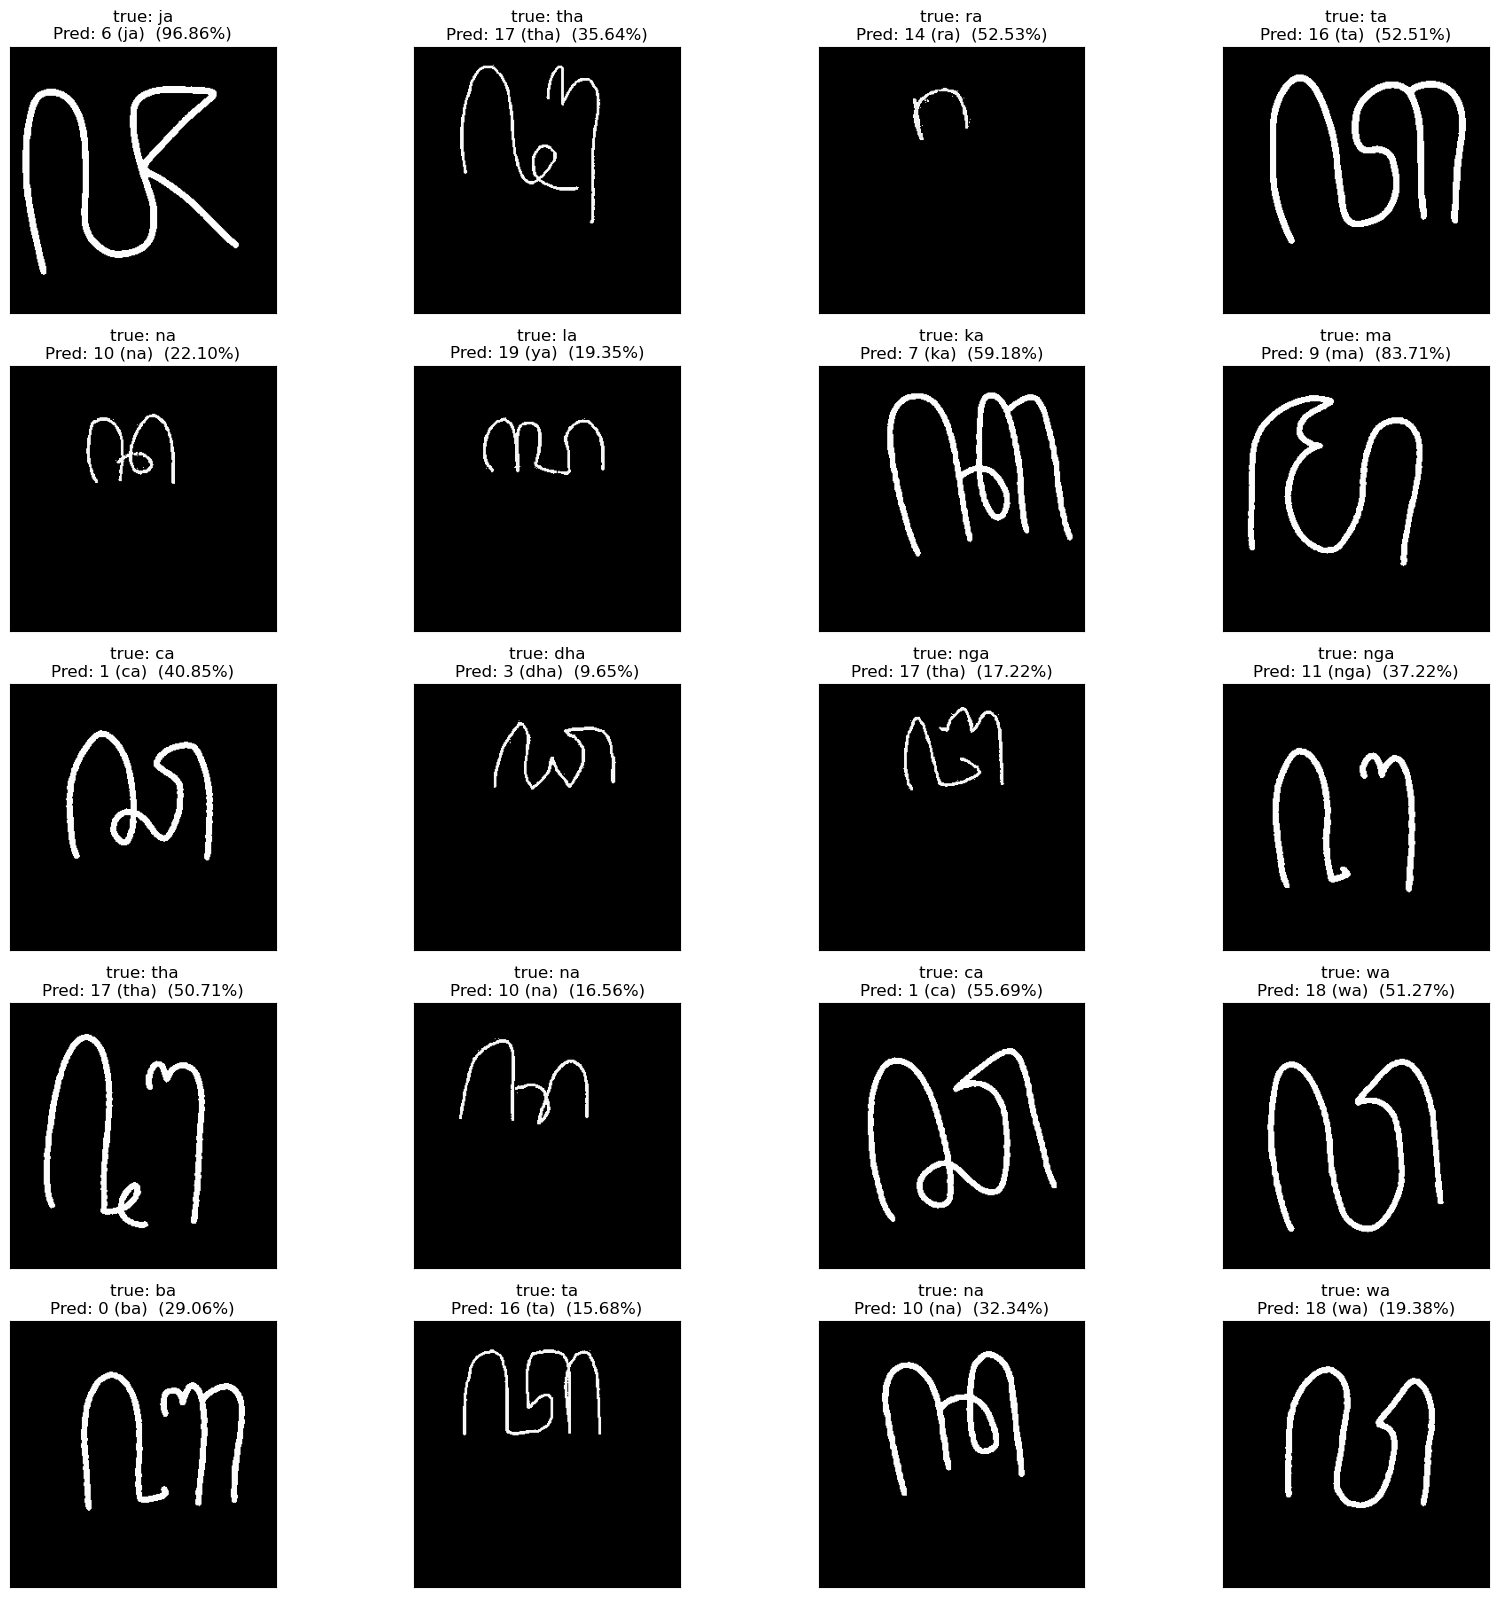

In [29]:
plot_images(test_ds_mapped, model=vgg_transferred_full, n_rows=5)

In [30]:
vgg_transferred_full.save(name+'.h5')

### Half Freeze

In [31]:
# VGG16

vgg = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

vgg.trainable = True

In [32]:
num_layers = len(vgg.layers) // 2
num_layers

for i in range(num_layers):
    vgg.layers[i].trainable = False

In [33]:
name = 'aksara_jawa_vgg_half_freeze_v1'

vgg_transferred_half = Sequential([
    vgg,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
], name=name)

vgg_transferred_half.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

vgg_transferred_half.summary()

Model: "aksara_jawa_vgg_half_freeze_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                10260     
                                                                 
Total params: 14,724,948
Trainable params: 13,579,540
Non-trainable params: 1,145,408
_________________________________________________________________


In [34]:
# Print the trainable status of each layer
for layer in vgg_transferred_half.layers:
    print(f'{layer.name}: {layer.trainable}')

vgg16: True
global_average_pooling2d_1: True
dropout_1: True
dense_1: True


In [35]:
# plot_model(
#     vgg_transferred,
#     to_file='vgg_transferred.png',
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
# #     expand_nested=True,
#     dpi=96,
#     show_layer_activations=True
# )

In [36]:
print(f"\nTraining {name} Model: ")

# steps_per_epoch = len(X_train)
# STEPS_PER_EPOCH = 50

time = timer(None)
history_half = vgg_transferred_half.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(f"checkpoint-{name}.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH
)
time_taken = timer(time)
print(time_taken)


Training aksara_jawa_vgg_half_freeze_v1 Model: 
Epoch 1/50
107/107 [==============================] - 32s 235ms/step - loss: 3.0690 - accuracy: 0.0561 - val_loss: 2.9952 - val_accuracy: 0.0386
Epoch 2/50
107/107 [==============================] - 24s 226ms/step - loss: 3.0048 - accuracy: 0.0538 - val_loss: 2.9951 - val_accuracy: 0.0531
Epoch 3/50
107/107 [==============================] - 25s 227ms/step - loss: 2.9949 - accuracy: 0.0552 - val_loss: 2.9949 - val_accuracy: 0.0531
Epoch 4/50
107/107 [==============================] - 25s 228ms/step - loss: 2.9946 - accuracy: 0.0552 - val_loss: 2.9948 - val_accuracy: 0.0531
Epoch 5/50
107/107 [==============================] - 25s 227ms/step - loss: 2.9944 - accuracy: 0.0552 - val_loss: 2.9947 - val_accuracy: 0.0531
Epoch 6/50
107/107 [==============================] - 24s 224ms/step - loss: 2.9943 - accuracy: 0.0552 - val_loss: 2.9947 - val_accuracy: 0.0531
Epoch 7/50
107/107 [==============================] - 25s 225ms/step - loss: 2.99

In [37]:
test_loss, test_acc = vgg_transferred_half.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

7/7 [==============================] - 1s 112ms/step - loss: 2.9943 - accuracy: 0.0545
Loss    : 2.994
Accuracy: 5.446%


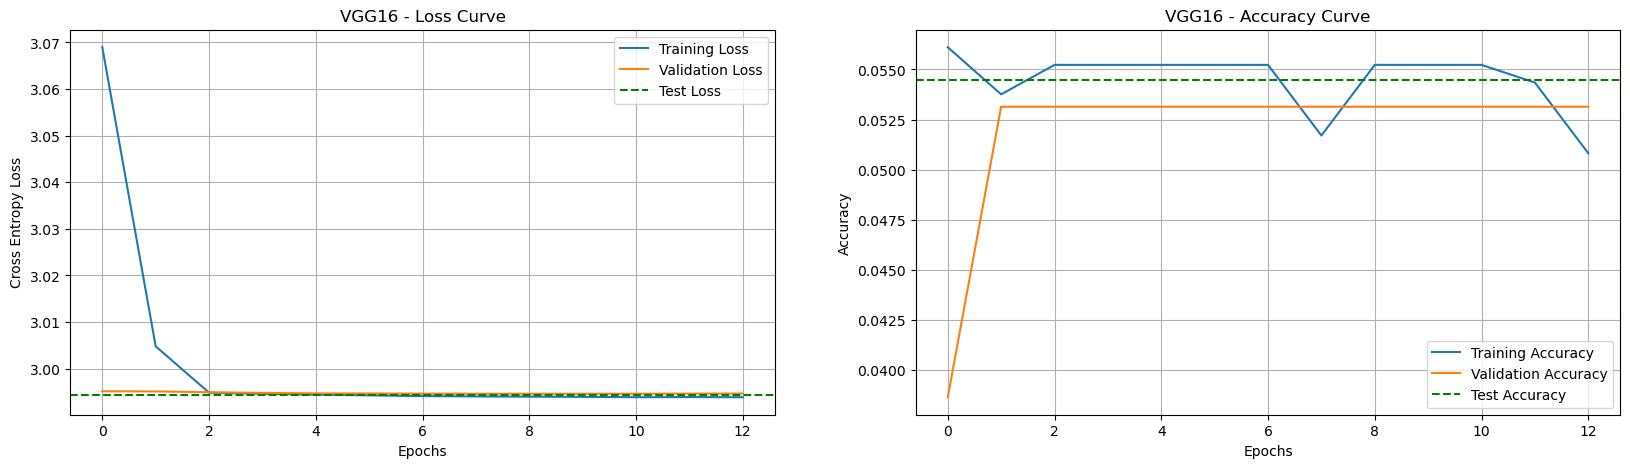

In [38]:
plot_history(history_half)

1/1 [==============================] - 0s 20ms/step


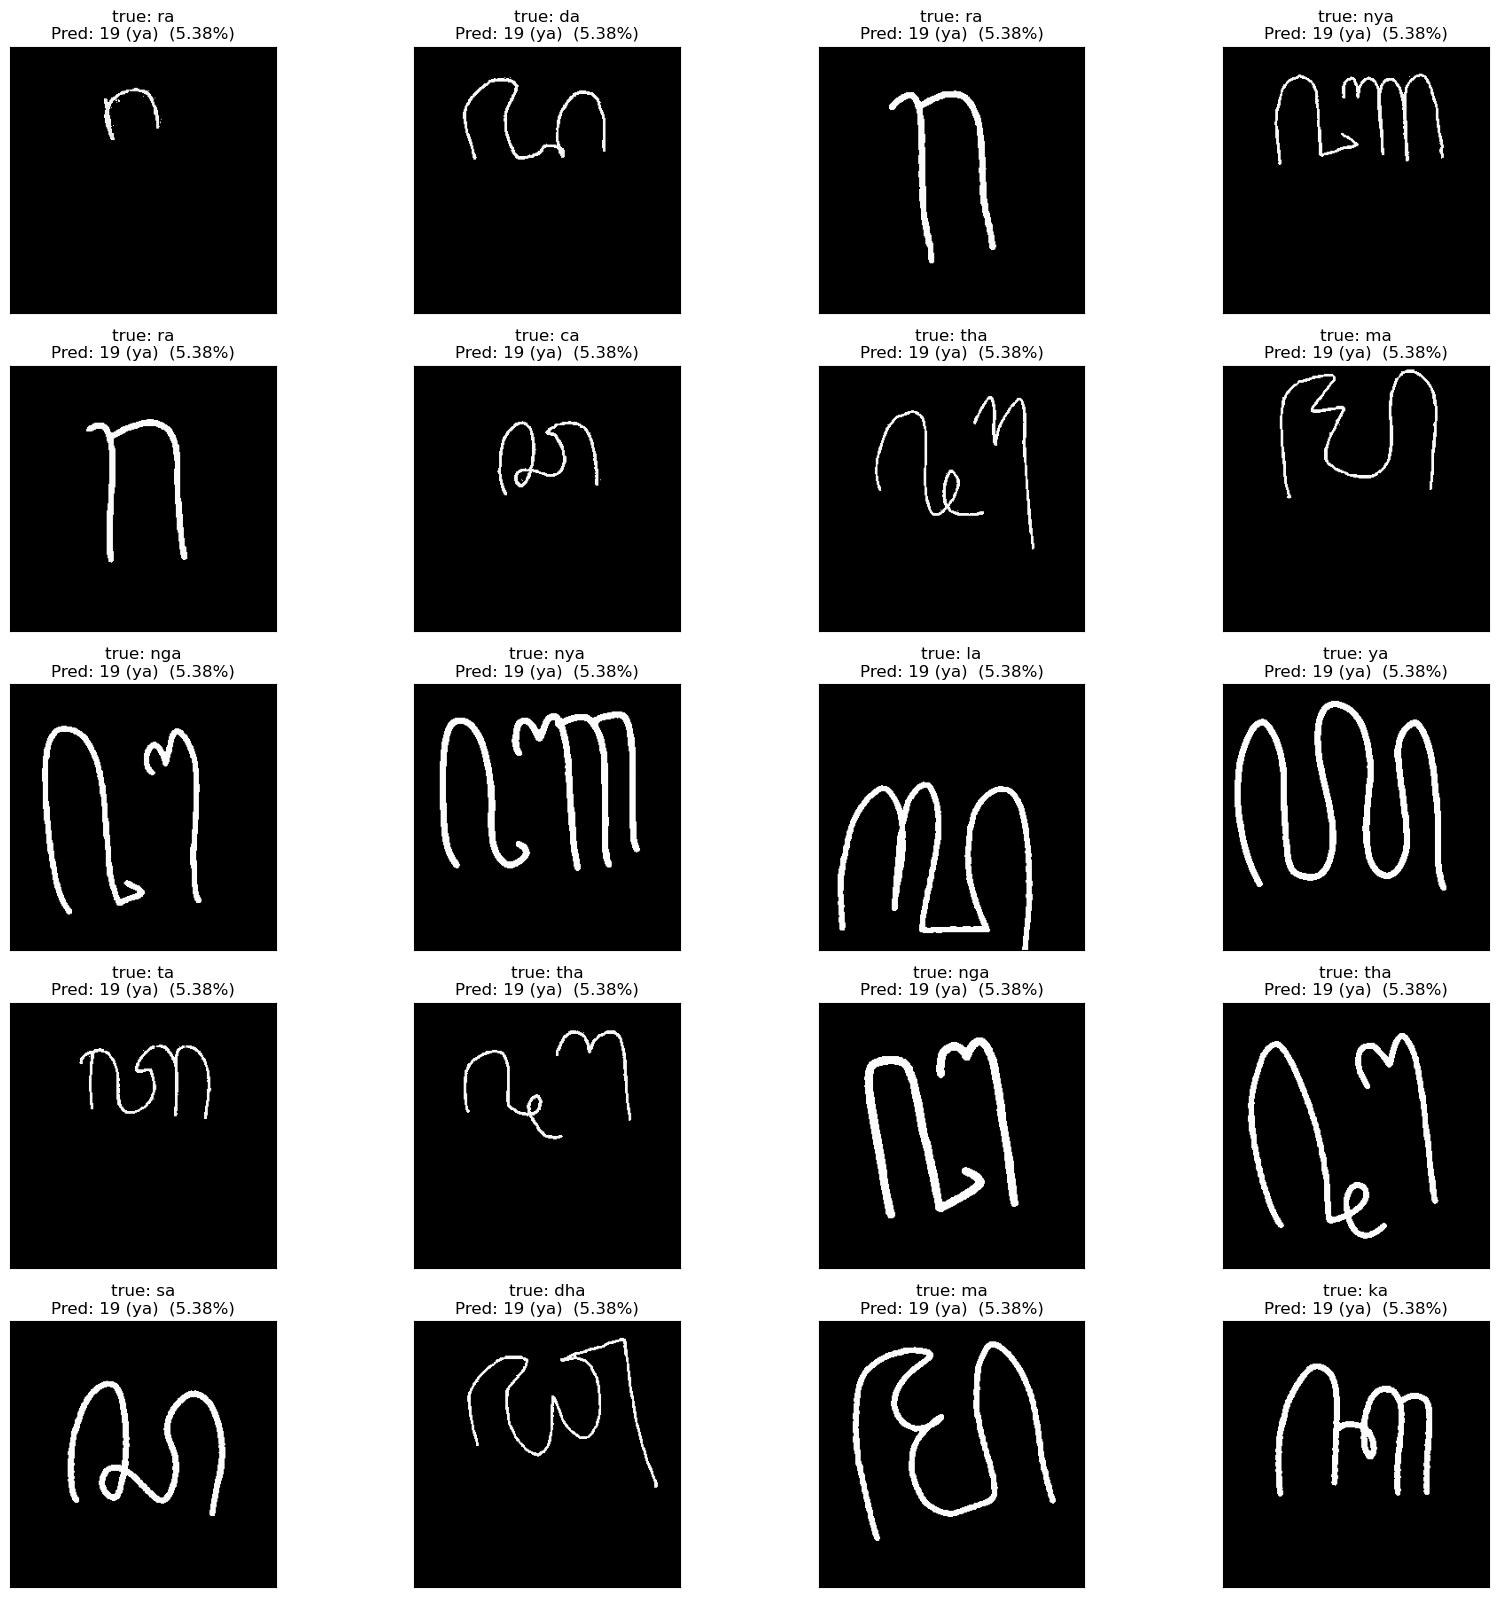

In [39]:
plot_images(test_ds_mapped, model=vgg_transferred_half, n_rows=5)

In [40]:
vgg_transferred_half.save(name+'.h5')

### No Freeze

In [41]:
# VGG16

vgg = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

vgg.trainable = True

In [42]:
name = 'aksara_jawa_vgg_no_freeze_v1'

vgg_transferred_no = Sequential([
    vgg,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
], name=name)

vgg_transferred_no.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

vgg_transferred_no.summary()

Model: "aksara_jawa_vgg_no_freeze_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                10260     
                                                                 
Total params: 14,724,948
Trainable params: 14,724,948
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Print the trainable status of each layer
for layer in vgg_transferred_no.layers:
    print(f'{layer.name}: {layer.trainable}')

vgg16: True
global_average_pooling2d_2: True
dropout_2: True
dense_2: True


In [44]:
print(f"\nTraining {name} Model: ")

# steps_per_epoch = len(X_train)
# STEPS_PER_EPOCH = 50

time = timer(None)
history_no = vgg_transferred_no.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(f"checkpoint-{name}.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH
)
time_taken = timer(time)
print(time_taken)


Training aksara_jawa_vgg_no_freeze_v1 Model: 
Epoch 1/50
107/107 [==============================] - 53s 418ms/step - loss: 3.2149 - accuracy: 0.0529 - val_loss: 2.9955 - val_accuracy: 0.0531
Epoch 2/50
107/107 [==============================] - 42s 388ms/step - loss: 2.9953 - accuracy: 0.0552 - val_loss: 2.9952 - val_accuracy: 0.0531
Epoch 3/50
107/107 [==============================] - 44s 403ms/step - loss: 2.9950 - accuracy: 0.0552 - val_loss: 2.9950 - val_accuracy: 0.0531
Epoch 4/50
107/107 [==============================] - 42s 390ms/step - loss: 2.9946 - accuracy: 0.0552 - val_loss: 2.9949 - val_accuracy: 0.0531
Epoch 5/50
107/107 [==============================] - 42s 389ms/step - loss: 2.9945 - accuracy: 0.0523 - val_loss: 2.9948 - val_accuracy: 0.0531
Epoch 6/50
107/107 [==============================] - 42s 388ms/step - loss: 2.9943 - accuracy: 0.0552 - val_loss: 2.9948 - val_accuracy: 0.0531
Epoch 7/50
107/107 [==============================] - 42s 391ms/step - loss: 2.9942

In [45]:
test_loss, test_acc = vgg_transferred_no.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

7/7 [==============================] - 1s 113ms/step - loss: 2.9942 - accuracy: 0.0545
Loss    : 2.994
Accuracy: 5.446%


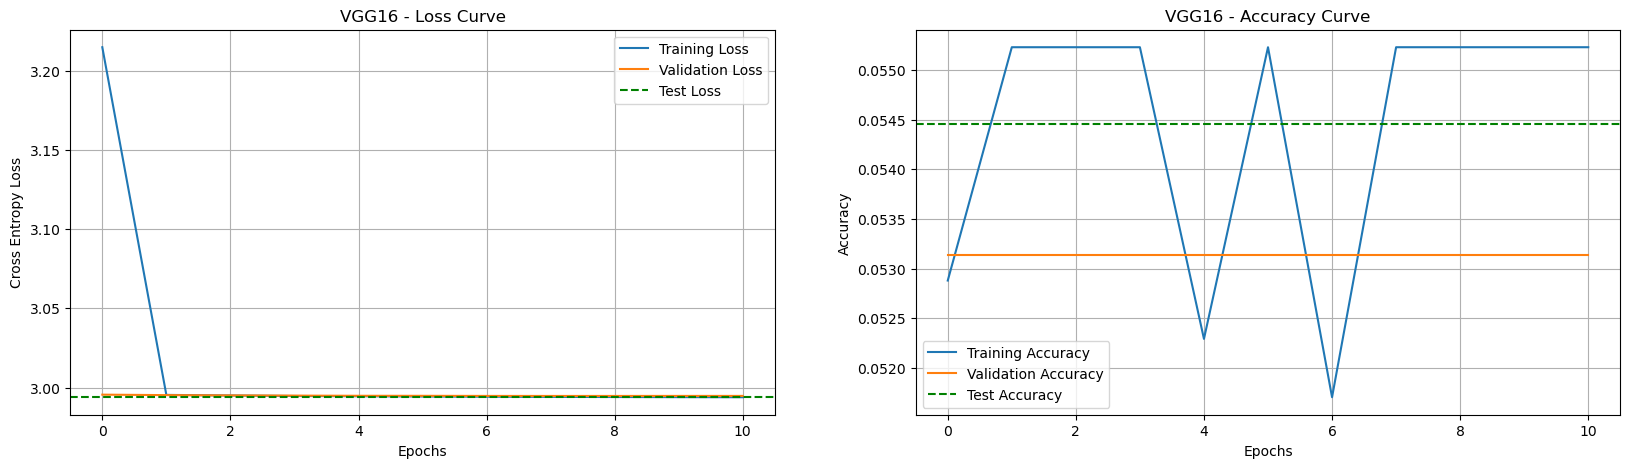

In [46]:
plot_history(history_no)

1/1 [==============================] - 0s 19ms/step


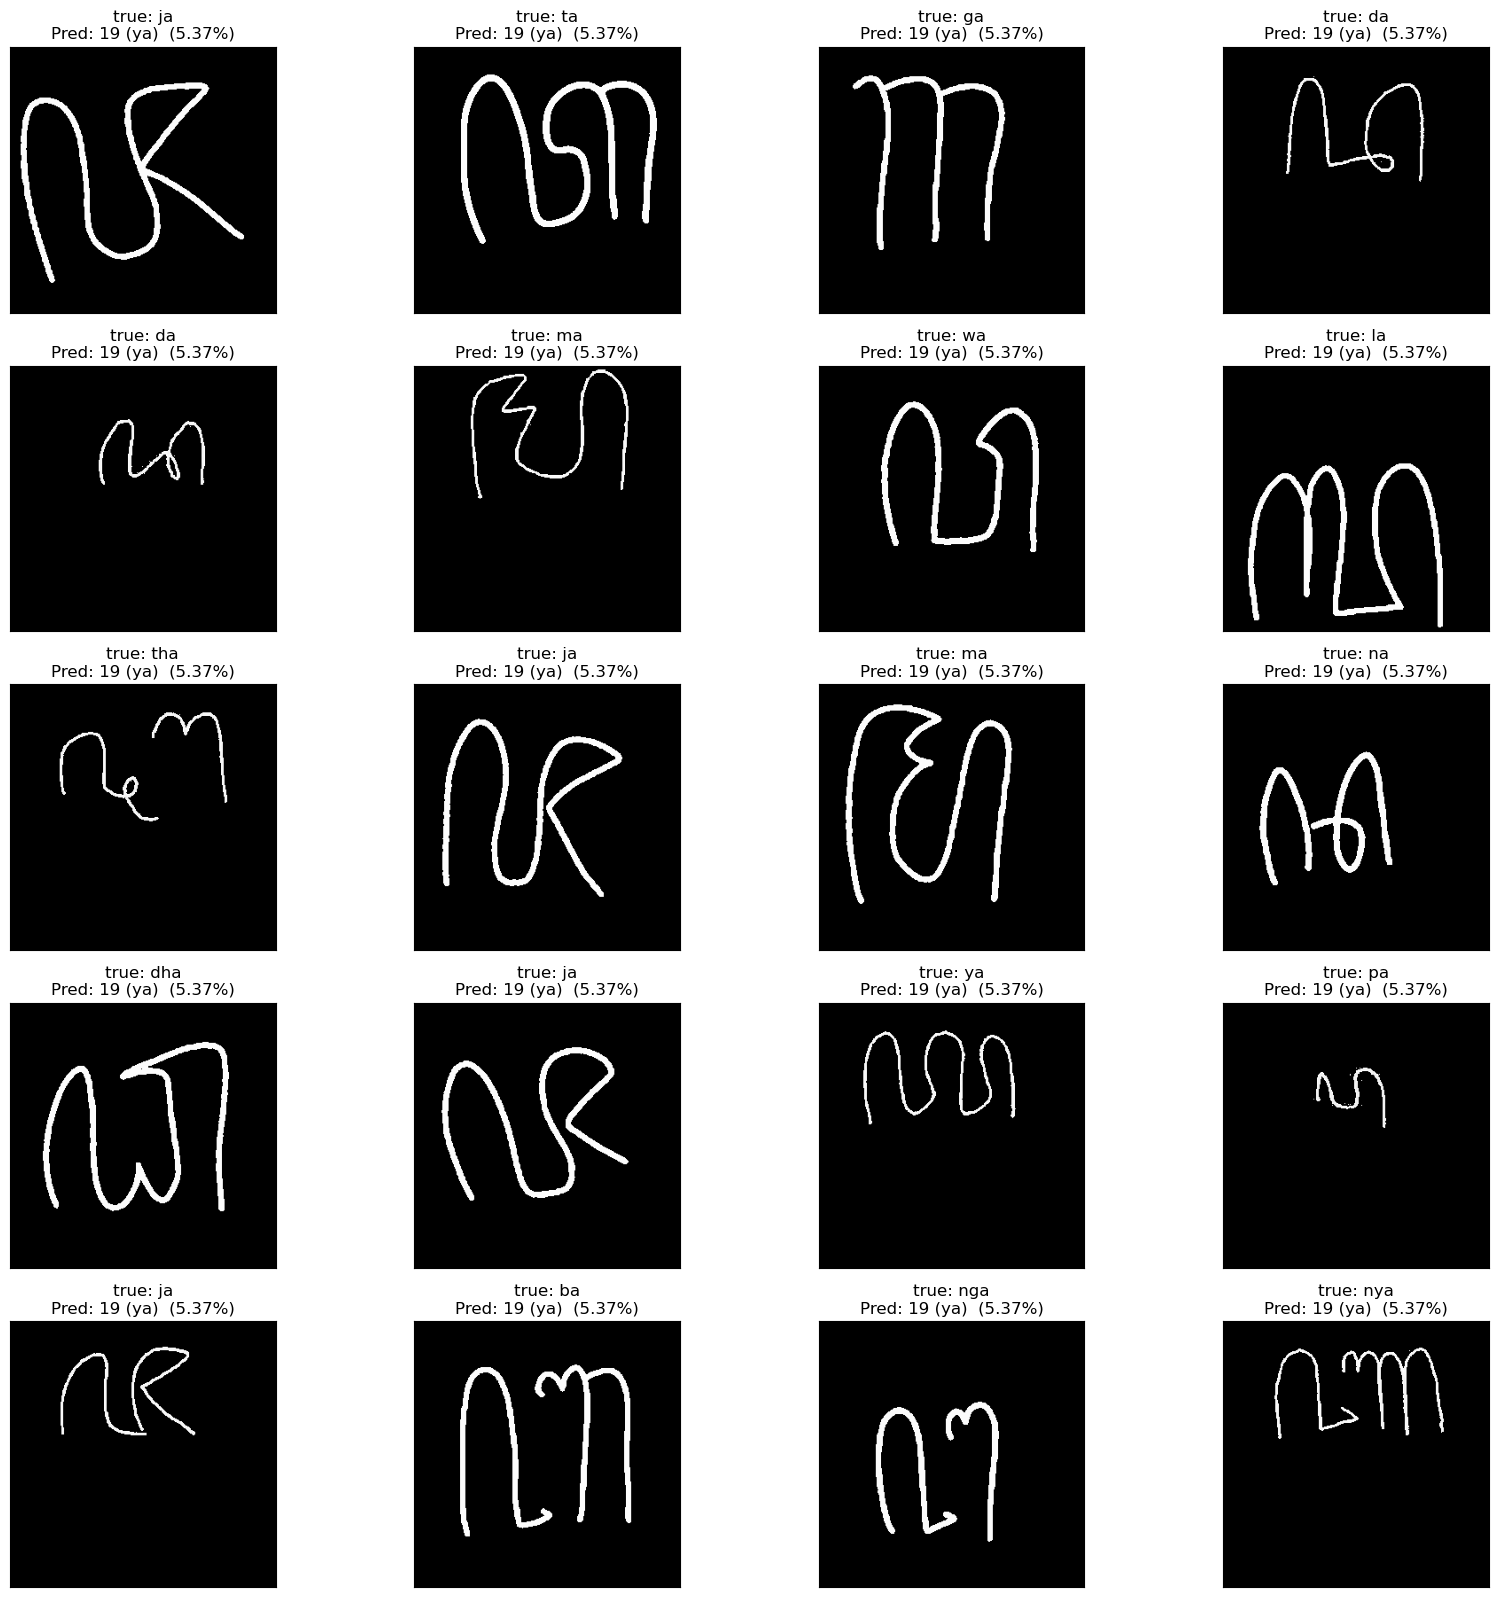

In [47]:
plot_images(test_ds_mapped, model=vgg_transferred_no, n_rows=5)

In [48]:
vgg_transferred_no.save(name+'.h5')